In [84]:
import os
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt
import functools
import operator
import matplotlib as mpl
import seaborn as sns

import math

%matplotlib inline

In [3]:
def read_idx(f):
    '''
    Read an IDX format data file - See http://yann.lecun.com/exdb/mnist/ for format specification.
        f: File name to read from. Can be either a .gz (gzip compressed) file or file without extension (uncompressed)
        returns: Numpy NDArray of data. The shape and dtype will match the data in the IDX file.
    '''
    type_dict = {
        0x08: np.dtype(np.uint8),
        0x09: np.dtype(np.int8),
        0x0B: np.dtype('>i2'), # short (2 bytes) 
        0x0C: np.dtype('>i4'), # int (4 bytes) 
        0x0D: np.dtype('>f4'), # float (4 bytes) 
        0x0E: np.dtype('>f8'), # double (8 bytes)
    }
    
    open_fn_dict = {'': open, '.gz': gzip.open}
    ext = os.path.splitext(f)[-1]    
    open_fn = open_fn_dict.get(ext)
    assert open_fn, f"Invalid extension in file {f} - do not know how to open this file"
    
    with open_fn(f, 'rb') as fd:
        # read magic number - first 4 bytes
        magic_num = fd.read(4)        
        assert magic_num[:2] == b'\x00\x00', f'Magic number in {f} does not match expected MNIST format 0x00 0x00.'
        
        # byte 4 is number of dimensions
        num_dimensions = magic_num[3]
        
        # byte 3 is dtype code.  Lookup the Numpy dtype using type_dict 
        dt = type_dict.get(magic_num[2])
        assert dt, f"3rd byte of magic number {magic_num[2]} in {f} is not valid MNIST type"
        
        #next set of UINTs are dimensions - read each, convert to int 
        dimensions = [int.from_bytes(fd.read(4), 'big') for i in range(num_dimensions)]  
        
        # total size of the data in bytes - (d1 * d2 * ... dn) * (size of dtype)
        size = functools.reduce(operator.mul, dimensions) * dt.itemsize
        assert size > 0, f"Invalid dimensions {dimensions} with resulting size 0 in file {f}"
        
        # read all data. 
        data = fd.read()
        assert len(data) == size, f'Expected {size} bytes from {f} but got {len(data)} bytes.'
        
        # build the ndarray from data
        bytes_array = np.frombuffer(data, dtype=dt).reshape(dimensions)
        return bytes_array

def show_digits(images, labels, nrows=6, ncols=5, figsize=(16,14)):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for ax, image, label in zip(axs.ravel(), images, labels):
        ax.imshow(image, cmap=mpl.cm.gray)
        ax.set_title(f'Label = {label}')
        ax.axis('off')
    plt.tight_layout()
        

In [4]:
d = r'DATA\MNIST' 

train_labels = read_idx(os.path.join(d, 'train-labels-idx1-ubyte.gz'))
train_images = read_idx(os.path.join(d, 'train-images-idx3-ubyte.gz'))
test_labels = read_idx(os.path.join(d, 't10k-labels-idx1-ubyte.gz'))
test_images = read_idx(os.path.join(d, 't10k-images-idx3-ubyte.gz'))

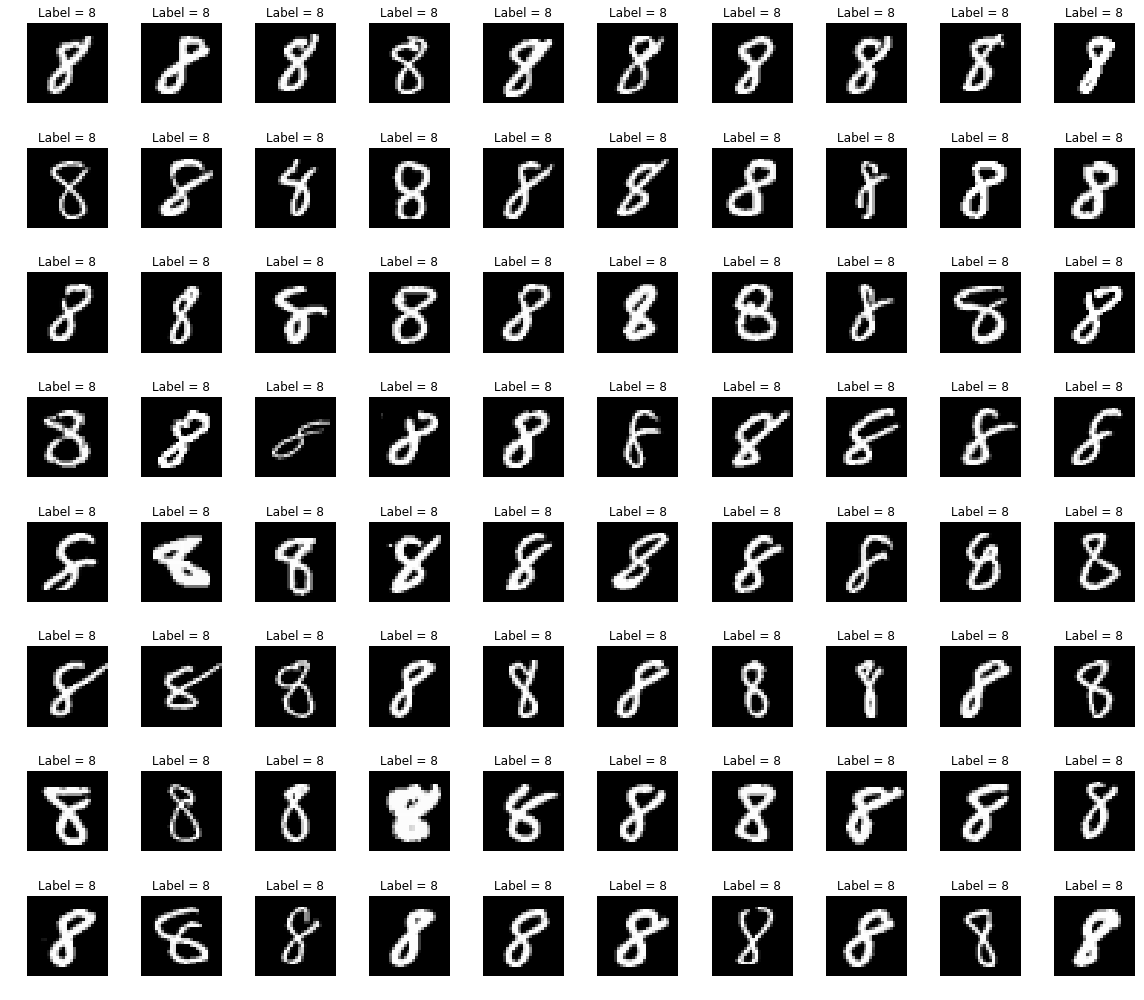

In [8]:
s = train_labels == 8
show_digits(train_images[s], train_labels[s], nrows=8, ncols=10)

In [46]:
def recognize_digit(a):
    digit = np.random.randint(10)
    return digit

correct = 0
for i in range(test_labels.shape[0]):
    if recognize_digit(train_images[i]) == test_labels[i]:
        correct += 1
        
print('Accuracy {:.2f}%'.format(100* correct / test_labels.shape[0]))

Accuracy 9.49%
